# LOAD MODEL AND SHOW METRICS

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path
import torch, torchvision
import numpy as np
import os, json, cv2, random
ROOT_DIR = 'F:/detectron2/'
assert os.path.exists(ROOT_DIR)
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
import glob
import imageio
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# register train data
register_coco_instances("train", {}, 
                        "F:/0_tents/train/8x/coco_instances.json", 
                        "F:/0_tents/train/8x/amostras")
# register val data
register_coco_instances("val", {}, 
                        "F:/0_tents/val/8x/coco_instances.json", 
                        "F:/0_tents/val/8x/amostras")
#register test data
register_coco_instances("test", {}, 
                        "F:/0_tents/test/8x/coco_instances.json", 
                        "F:/0_tents/test/8x/amostras")

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("7_channel_results/Resnet_101_FPN_7channel", exist_ok=True)
        output_folder = "7_channel_results/Resnet_101_FPN_7channel"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)

cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 1

cfg.SOLVER.BASE_LR = 0.000001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1    # 10k per net
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # number of classes + background

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

#class_names = ['BG', 'BSU']

cfg.MODEL.BACKBONE.FREEZE_AT = 0

cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/03 13:21:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/03 13:21:20 d2.data.datasets.coco]: Loaded 186 images in COCO format from F:/0_tents/train/8x/coco_instances.json
[02/03 13:21:20 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    tent    | 1780         |
|            |              |
[02/03 13:21:20 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[02/03 13:21:20 d2.data.common]: Serialized dataset takes 0.63 MiB
[02/03 13:21:20 d2.data.dataset_mapper]: Augmentations used in training: [RandomFlip(), RandomFlip(horizontal=False, vertical=True)]
[02/03 13:21:20 d2.data.build]: Using training sampler TrainingSampler
[02/03 13:21:21 d2.engine.train_loop]: Starting training from iteration 0
[02/03 13:21:26 d2.data.datasets.coco]: Loaded 42 images in COCO format from F:/0_tents/val/8x/coco_instances.json
[02/03 13:21:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:-

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
#evaluator = SemSegEvaluator("test", distributed=True, num_classes=1, ignore_label=255, output_dir="./output/")
evaluator = COCOEvaluator("test", cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[02/03 13:21:33 d2.data.datasets.coco]: Loaded 50 images in COCO format from F:/0_tents/test/8x/coco_instances.json
[02/03 13:21:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    tent    | 771          |
|            |              |
[02/03 13:21:33 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[02/03 13:21:33 d2.data.common]: Serialized dataset takes 0.27 MiB
[02/03 13:21:33 d2.data.dataset_mapper]: Augmentations used in training: []
[02/03 13:21:33 d2.evaluation.evaluator]: Start inference on 50 images
[02/03 13:21:33 d2.evaluation.evaluator]: Inference done 11/50. 0.0583 s / img. ETA=0:00:03
[02/03 13:21:37 d2.evaluation.evaluator]: Total inference time: 0:00:03.768991 (0.083755 s / img per device, on 1 devices)
[02/03 13:21:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.055562 s / img per device, on 1 devices)
[02/03 13:21:37 d2.e

OrderedDict([('bbox',
              {'AP': 53.11084474843136,
               'AP50': 94.28992814053863,
               'AP75': 52.342827478620094,
               'APs': 25.898861470056627,
               'APm': 55.556475339059176,
               'APl': 56.71948811259028}),
             ('segm',
              {'AP': 52.41042100865676,
               'AP50': 94.20748879835816,
               'AP75': 51.81087378970184,
               'APs': 21.035285380962442,
               'APm': 55.079349761634525,
               'APl': 60.421221731267})])

# LOAD LARGE IMAGE

In [3]:
# lood image
loaded = np.load("img_corte_1.npz")
image = loaded['x']

del loaded

# load three bands for showing
image_rgb_full = image[:,:,1:4]

# LOAD MODEL

In [4]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.92   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("test")

In [5]:
torch_mask = torch.zeros(204,3072,2048)
print(torch_mask.shape)

torch.Size([204, 3072, 2048])


# SLIDING WINDOW MOSAICKING

In [6]:
import matplotlib.pyplot as plt

dim_count = 0

# BASE CLASSIFIER
for row in range(0, 3072, 512):
    for col in range(0, 2048, 512):
        
        if not(row == 0 and col ==0):
            dim_count = all_box_tensor.cpu().numpy().shape[0]
        
        actual_count = 0
        
        actual_image = image[row:row+512, col:col+512, :]
        outputs = predictor(actual_image)
        
        new_box_tensor = outputs['instances'].pred_boxes.tensor.cpu()
        
        actual_count = new_box_tensor.cpu().numpy().shape[0]
        
        new_scores = outputs['instances'].scores.cpu()
        new_pred_classes = outputs['instances'].pred_classes.cpu()
        new_pred_mask = outputs['instances'].pred_masks
        
        for pos_mask in range(0, new_box_tensor.shape[0]):
            torch_mask[pos_mask+dim_count, row:row+512, col:col+512] = new_pred_mask[pos_mask,:,:]
        
        for pos in range(0, new_box_tensor.shape[0]):
            new_box_tensor[pos][0] += col
            new_box_tensor[pos][1] += row
            new_box_tensor[pos][2] += col
            new_box_tensor[pos][3] += row
        
        if row == 0 and col == 0:
            all_box_tensor = new_box_tensor
            all_scores = new_scores
            all_pred_classes = new_pred_classes
        else:
            all_box_tensor = torch.cat([all_box_tensor, new_box_tensor], dim=0)
            print('box',all_box_tensor.cpu().numpy().shape[0])
            all_scores = torch.cat([all_scores, new_scores], dim=0)
            all_pred_classes = torch.cat([all_pred_classes, new_pred_classes], dim=0)

# HORIZONTAL EDGE CLASSIFIER
for row in range(0, 3072, 512):
    for col in range(256, 2048-256, 512):
        actual_count = 0
        dim_count = all_box_tensor.cpu().numpy().shape[0]

        actual_img = image[row:row+512, col:col+512, :]
        outputs = predictor(actual_img)
    
        bx = outputs['instances'].pred_boxes.tensor.cpu().numpy()
        
        list_indexes=[]

        for k in range(0, bx.shape[0]):
            if not(bx[k][0] < (256) and bx[k][2] > (256)):
                list_indexes.append(k)
                
        new_boxes = outputs['instances'].pred_boxes.tensor
        new_boxes = np.delete(new_boxes.cpu(), list_indexes, axis=0)
        
        new_box_tensor = new_boxes
        
        actual_count = new_box_tensor.cpu().numpy().shape[0]

        new_scores = outputs['instances'].scores
        new_scores = np.delete(new_scores.cpu(), list_indexes)
        
        new_pred_classes = outputs['instances'].pred_classes
        new_pred_classes = np.delete(new_pred_classes.cpu(), list_indexes)
        
        new_mask = outputs['instances'].pred_masks
        new_mask = np.delete(new_mask.cpu(), list_indexes,axis=0)
        
        for pos_mask in range(0, new_box_tensor.shape[0]):
            torch_mask[pos_mask+dim_count, row:row+512, col:col+512] = new_mask[pos_mask,:,:]
        
        #torch_mask[dim_count:dim_count+actual_count, row:row+512, col:col+512] = new_mask
        
        for pos in range(0, new_box_tensor.shape[0]):
            new_box_tensor[pos][0] += col
            new_box_tensor[pos][1] += row
            new_box_tensor[pos][2] += col
            new_box_tensor[pos][3] += row
        
        all_box_tensor = torch.cat([all_box_tensor, new_box_tensor], dim=0)
        all_scores = torch.cat([all_scores, new_scores], dim=0)
        all_pred_classes = torch.cat([all_pred_classes, new_pred_classes], dim=0)

# VERTICAL EDGE CLASSIFIER
for row in range(256, 3072-256, 512):
    for col in range(0, 2048, 512):
        actual_count = 0
        dim_count = all_box_tensor.cpu().numpy().shape[0]

        actual_img = image[row:row+512, col:col+512, :]
        outputs = predictor(actual_img)
    
        bx = outputs['instances'].pred_boxes.tensor.cpu().numpy()
        
        list_indexes=[]

        for k in range(0, bx.shape[0]):
            if not(bx[k][1] < (256) and bx[k][3] > (256)):
                list_indexes.append(k)
                
        new_boxes = outputs['instances'].pred_boxes.tensor
        new_boxes = np.delete(new_boxes.cpu(), list_indexes, axis=0)
        
        new_box_tensor = new_boxes
        
        actual_count = new_box_tensor.cpu().numpy().shape[0]

        new_scores = outputs['instances'].scores
        new_scores = np.delete(new_scores.cpu(), list_indexes)
        
        new_pred_classes = outputs['instances'].pred_classes
        new_pred_classes = np.delete(new_pred_classes.cpu(), list_indexes)
        
        new_mask = outputs['instances'].pred_masks
        new_mask = np.delete(new_mask.cpu(), list_indexes,axis=0)
        
        for pos_mask in range(0, new_box_tensor.shape[0]):
            torch_mask[pos_mask+dim_count, row:row+512, col:col+512] = new_mask[pos_mask,:,:]
        
        #torch_mask[dim_count:dim_count+actual_count, row:row+512, col:col+512] = new_mask
        
        for pos in range(0, new_box_tensor.shape[0]):
            new_box_tensor[pos][0] += col
            new_box_tensor[pos][1] += row
            new_box_tensor[pos][2] += col
            new_box_tensor[pos][3] += row
        
        all_box_tensor = torch.cat([all_box_tensor, new_box_tensor], dim=0)
        all_scores = torch.cat([all_scores, new_scores], dim=0)
        all_pred_classes = torch.cat([all_pred_classes, new_pred_classes], dim=0)
        
# DOUBLE EDGE CLASSIFIER
for row in range(256, 3072-256, 512):
    for col in range(256, 2048-256, 512):
        actual_count = 0
        dim_count = all_box_tensor.cpu().numpy().shape[0]

        actual_img = image[row:row+512, col:col+512, :]
        outputs = predictor(actual_img)
    
        bx = outputs['instances'].pred_boxes.tensor.cpu().numpy()
        
        list_indexes=[]

        for k in range(0, bx.shape[0]):
            if not(bx[k][1] < (256) and bx[k][3]) > (256):
                list_indexes.append(k)
                
            elif not(bx[k][0] < (256) and bx[k][2] > (256)):
                list_indexes.append(k)
                
        new_boxes = outputs['instances'].pred_boxes.tensor
        new_boxes = np.delete(new_boxes.cpu(), list_indexes, axis=0)
        
        new_box_tensor = new_boxes
        
        actual_count = new_box_tensor.cpu().numpy().shape[0]

        new_scores = outputs['instances'].scores
        new_scores = np.delete(new_scores.cpu(), list_indexes)
        
        new_pred_classes = outputs['instances'].pred_classes
        new_pred_classes = np.delete(new_pred_classes.cpu(), list_indexes)
        
        new_mask = outputs['instances'].pred_masks
        new_mask = np.delete(new_mask.cpu(), list_indexes,axis=0)
        
        for pos_mask in range(0, new_box_tensor.shape[0]):
            torch_mask[pos_mask+dim_count, row:row+512, col:col+512] = new_mask[pos_mask,:,:]
        
        for pos in range(0, new_box_tensor.shape[0]):
            new_box_tensor[pos][0] += col
            new_box_tensor[pos][1] += row
            new_box_tensor[pos][2] += col
            new_box_tensor[pos][3] += row
        
        all_box_tensor = torch.cat([all_box_tensor, new_box_tensor], dim=0)
        all_scores = torch.cat([all_scores, new_scores], dim=0)
        all_pred_classes = torch.cat([all_pred_classes, new_pred_classes], dim=0)


outputs['instances'].pred_boxes.tensor = all_box_tensor
outputs['instances'].scores = all_scores
outputs['instances'].pred_classes = all_pred_classes
outputs['instances'].pred_masks = torch_mask

box 15
box 15
box 15
box 26
box 42
box 42
box 42
box 44
box 64
box 71
box 71
box 71
box 74
box 95
box 95
box 95
box 106
box 134
box 139
box 142
box 148
box 152
box 157


# NON MAX SUPRESSION

In [7]:
import numpy as np


# Malisiewicz et al.
def non_max_suppression_fast(bbox, overlap_threshold):
    
    if len(bbox) == 0:
        return []
    
    box_list = []
    x1 = bbox[:,0]
    y1 = bbox[:,1]
    x2 = bbox[:,2]
    y2 = bbox[:,3]
    
    area = (x2-x1 + 1)*(y2-y1 + 1)
    
    #AREA SORTING
    indexes = np.argsort(area)
    
    while len(indexes) > 0:
        #print(area)
        
        last = len(indexes) - 1
        i = indexes[last]
        box_list.append(i)
        
        xx1 = np.maximum(x1[i], x1[indexes[:last]])
        yy1 = np.maximum(y1[i], y1[indexes[:last]])
        xx2 = np.minimum(x2[i], x2[indexes[:last]])
        yy2 = np.minimum(y2[i], y2[indexes[:last]])
        
        width = np.maximum(0, xx2 - xx1 + 1)
        height = np.maximum(0, yy2 - yy1 + 1)

        overlap_area = (width * height) / area[indexes[:last]]

        indexes = np.delete(indexes, np.concatenate(([last], np.where(overlap_area > overlap_threshold)[0])))
         
    return box_list

In [8]:
test_array = non_max_suppression_fast(outputs['instances'].pred_boxes.tensor.cpu().numpy(), 0.3)

In [9]:
create_list = []

for i in range(0, outputs['instances'].pred_boxes.tensor.cpu().numpy().shape[0]):
    create_list.append(i)

In [10]:
del_items = [element for element in create_list if element not in test_array]

In [ ]:
len(del_items)

In [11]:
all_box_tensor = np.delete(all_box_tensor, del_items, axis=0)
all_scores = np.delete(all_scores, del_items, axis=0)
all_pred_classes = np.delete(all_pred_classes, del_items, axis=0)
#torch_mask = torch_mask.cpu().numpy().astype('uint8')
torch_mask = np.delete(torch_mask, del_items,axis=0)

In [ ]:
all_box_tensor = np.delete(all_box_tensor, test_array, axis=0)
all_scores = np.delete(all_scores, test_array, axis=0)
all_pred_classes = np.delete(all_pred_classes, test_array, axis=0)
#torch_mask = torch_mask.cpu().numpy().astype('uint8')
torch_mask = np.delete(torch_mask, test_array,axis=0)

In [16]:
torch_mask.shape

torch.Size([148, 3072, 2048])

In [12]:
outputs['instances'].pred_boxes.tensor = all_box_tensor
outputs['instances'].scores = all_scores
outputs['instances'].pred_classes = all_pred_classes
outputs['instances'].pred_masks = torch_mask

# SHOW LARGE IMAGE

In [13]:
test_metadata.thing_colors = [(255, 0, 0)]

In [14]:
v = Visualizer(image_rgb_full/4.2, metadata=test_metadata, scale=1, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs['instances'].to('cpu'))

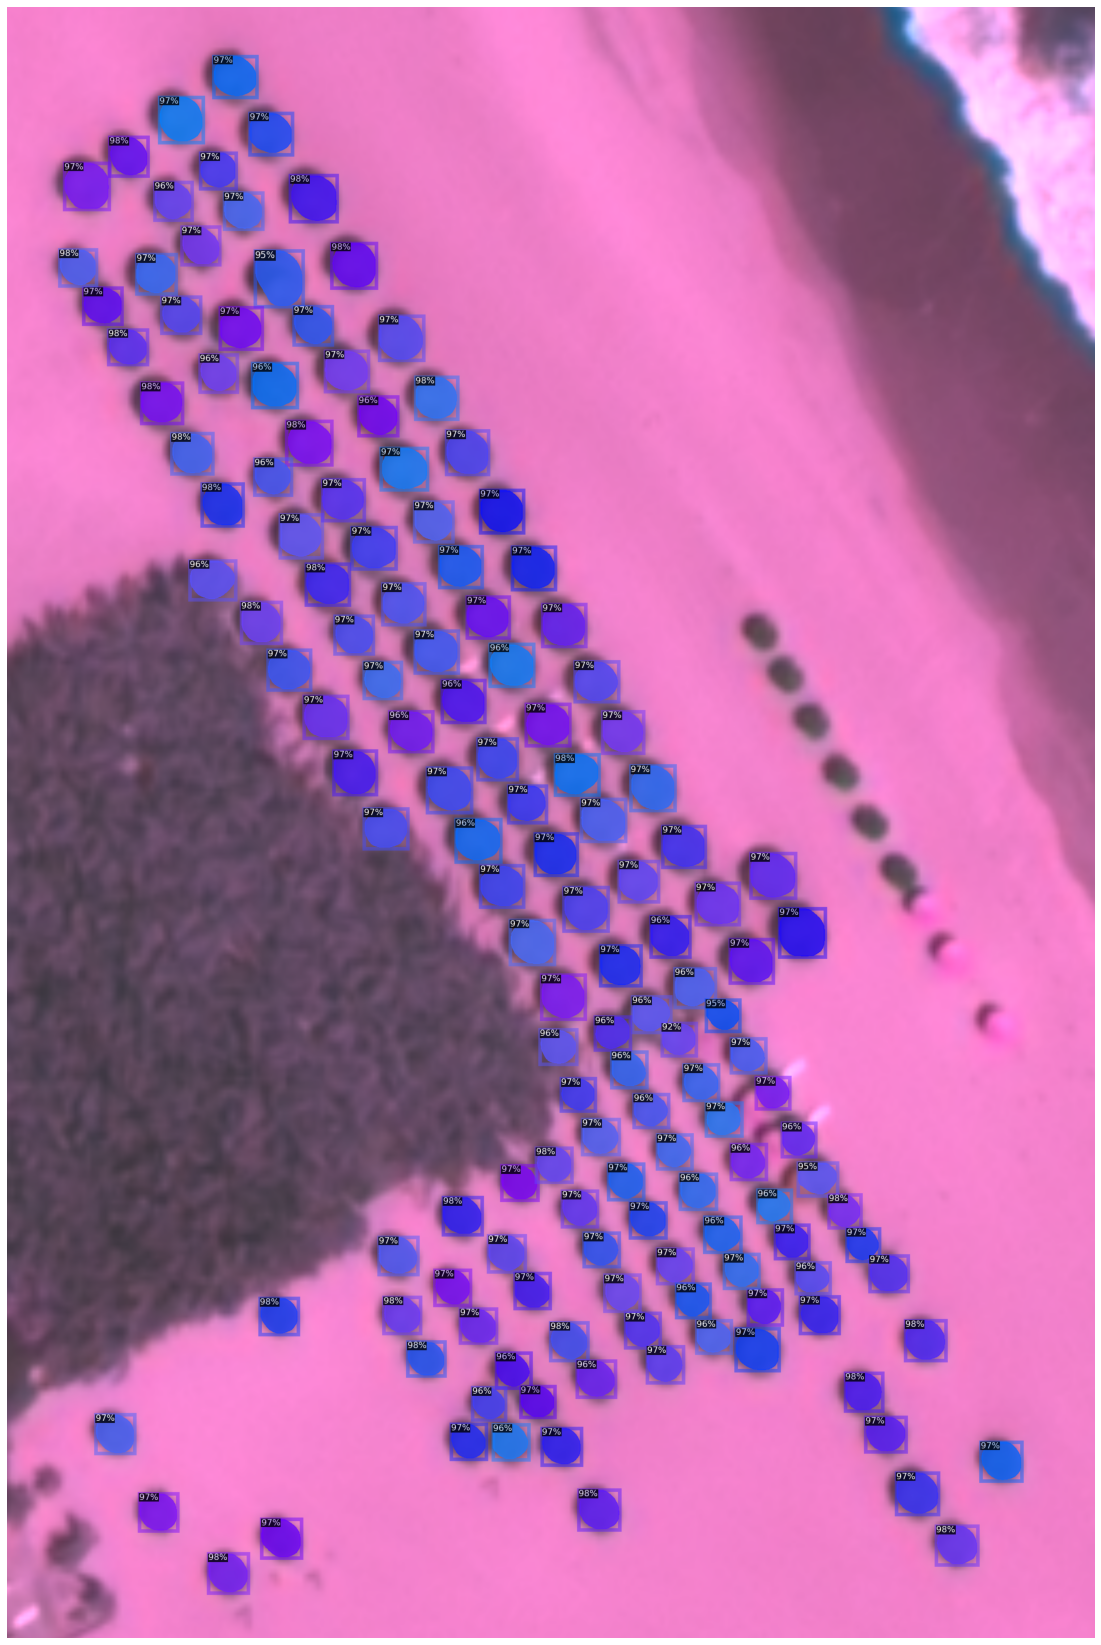

In [15]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(out.get_image()[:, :, ::-1])

plt.show()

In [ ]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(out.get_image()[:, :, ::-1])

#plt.savefig('paper_images1/full_image/bahia_full_white_background.tiff', dpi=800, bbox_inches='tight', pad_inches=0)

plt.show()

In [17]:
list_of_areas = []
for i in range(0,148):
    area = np.sum(torch_mask[i,:,:].numpy()>0)
    list_of_areas.append(area)

In [18]:
list_of_areas

[3967,
 5942,
 3913,
 5440,
 4783,
 3443,
 3782,
 3801,
 5912,
 3641,
 4753,
 4476,
 4766,
 3833,
 3715,
 4732,
 3612,
 5266,
 4898,
 5116,
 4176,
 5189,
 3889,
 4708,
 5300,
 5545,
 4880,
 4050,
 4689,
 4976,
 5338,
 4520,
 4718,
 5189,
 3928,
 5190,
 4795,
 5107,
 3727,
 4746,
 5090,
 5019,
 4877,
 5442,
 4675,
 4717,
 4805,
 4993,
 3150,
 5684,
 5305,
 4599,
 4911,
 5338,
 4329,
 3658,
 4269,
 3292,
 3116,
 4380,
 2745,
 2989,
 4089,
 3633,
 3374,
 4005,
 3384,
 3559,
 3292,
 3396,
 3411,
 3241,
 3106,
 3111,
 3179,
 3358,
 2981,
 3336,
 3347,
 3500,
 3412,
 3071,
 3266,
 2984,
 3522,
 2764,
 3349,
 3101,
 3275,
 2978,
 2693,
 4443,
 3808,
 2754,
 4252,
 3965,
 4142,
 3270,
 3518,
 2855,
 4461,
 3894,
 4329,
 4299,
 3734,
 4908,
 4797,
 5450,
 3605,
 4505,
 4703,
 5185,
 4970,
 5359,
 5365,
 4930,
 3316,
 6473,
 3689,
 3630,
 3345,
 3920,
 2765,
 3281,
 4220,
 3939,
 2916,
 3597,
 4350,
 5534,
 5148,
 4832,
 5120,
 4705,
 3841,
 5219,
 5313,
 2920,
 3272,
 2837,
 2985,
 3457,
 3040,

In [19]:
import statistics
statistics.median(list_of_areas)

4027.5

In [ ]:
import math
sqrt(4364)

In [20]:
statistics.mean(list_of_areas)

4172

In [21]:
statistics.stdev(list_of_areas)

161.62611175178347

In [23]:
min(list_of_areas)

2693